# Regression Modelling

Preprocess Data & Run Regression Algorithms to determine the importance / success of different promotions for different customer segments.


### Data Sources

Cleaned datafile, as prepared in notebook 1:
- profile_long_clean.csv - demographic data, offer data and transaction data for each customer

### Changes

- 2019-01-10: Started notebook



In [4]:
# load libraries

import numpy as np
import pandas as pd
from tqdm import tqdm

# my own custom functions
import EDA_functions as EDA
import cleaning_functions as cleaning
from linRegModel_class import LinRegModel 

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample  # for error calculation of feature weights

# visualization
import matplotlib.pyplot as plt
import seaborn as sns #, sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# display settings
from IPython.display import display
pd.options.display.max_columns = None

from pathlib import Path  # to make file path references relative to notebook directory

In [5]:
# import data

profile_file = Path.cwd() / "data" / "processed" / "profile_long_clean.csv"
profile = pd.read_csv(profile_file, index_col = 0)

## Explore profile (long) data

In [6]:
display(profile.head())
display(profile.info())

,age,gender,income,member_days,"('o_1', 'offer received')","('o_1', 'offer viewed')","('o_1', 'offer completed')","('o_1', 'transactions')","('o_2', 'offer received')","('o_2', 'offer viewed')","('o_2', 'offer completed')","('o_2', 'transactions')","('o_3', 'offer received')","('o_3', 'offer viewed')","('o_3', 'offer completed')","('o_3', 'transactions')","('o_4', 'offer received')","('o_4', 'offer viewed')","('o_4', 'offer completed')","('o_4', 'transactions')","('o_5', 'offer received')","('o_5', 'offer viewed')","('o_5', 'offer completed')","('o_5', 'transactions')","('o_6', 'offer received')","('o_6', 'offer viewed')","('o_6', 'offer completed')","('o_6', 'transactions')","('o_7', 'offer received')","('o_7', 'offer viewed')","('o_7', 'offer completed')","('o_7', 'transactions')","('o_8', 'offer received')","('o_8', 'offer viewed')","('o_8', 'offer completed')","('o_8', 'transactions')","('o_9', 'offer received')","('o_9', 'offer viewed')","('o_9', 'offer completed')","('o_9', 'transactions')","('o_10', 'offer received')","('o_10', 'offer viewed')","('o_10', 'offer completed')","('o_10', 'transactions')",total_amount
p_1,NaN,NaN,NaN,-529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.0,1.0,1.0,1.0,5.0,2.0,2.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.40
p_10,NaN,NaN,NaN,-611,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,15.62
p_100,68.0,F,84000.0,-725,1.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,2.0,NaN,0.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,1.0,NaN,1.0,1.0,1.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,34.04
p_1000,67.0,M,44000.0,-225,0.0,0.0,NaN,0.0,1.0,1.0,NaN,1.0,0.0,0.0,NaN,0.0,2.0,2.0,NaN,2.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,1.0,1.0,NaN,1.0,19.78
p_10000,NaN,NaN,NaN,-446,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,1.0,1.0,NaN,3.0,1.0,1.0,NaN,2.0,0.0,0.0,NaN,0.0,1.0,1.0,NaN,3.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,7.28


<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, p_1 to p_9999
Data columns (total 45 columns):
age                            14825 non-null float64
gender                         14825 non-null object
income                         14825 non-null float64
member_days                    17000 non-null int64
('o_1', 'offer received')      16994 non-null float64
('o_1', 'offer viewed')        16834 non-null float64
('o_1', 'offer completed')     12774 non-null float64
('o_1', 'transactions')        16578 non-null float64
('o_2', 'offer received')      16994 non-null float64
('o_2', 'offer viewed')        16834 non-null float64
('o_2', 'offer completed')     12774 non-null float64
('o_2', 'transactions')        16578 non-null float64
('o_3', 'offer received')      16994 non-null float64
('o_3', 'offer viewed')        16834 non-null float64
('o_3', 'offer completed')     12774 non-null float64
('o_3', 'transactions')        16578 non-null float64
('o_4', 'offer received')      1

None

In [8]:
profile.describe()

,age,income,member_days,offer_received,offer_viewed,offer_completed,transactions,total_amount,mean_amount
count,14825.000000,14825.000000,17000.000000,16994.000000,16834.000000,12774.000000,16578.000000,17000.000000,16578.000000
mean,54.393524,65404.991568,-517.449882,4.488467,3.429072,2.628699,8.381771,104.438351,13.680266
std,17.383705,21598.299410,411.223904,1.073047,1.259239,1.308750,5.009822,125.922619,16.056763
min,18.000000,30000.000000,-1823.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.050000
25%,42.000000,49000.000000,-791.000000,4.000000,3.000000,2.000000,5.000000,21.820000,3.181392
50%,55.000000,64000.000000,-358.000000,5.000000,3.000000,3.000000,7.000000,69.405000,11.996607
75%,66.000000,80000.000000,-208.000000,5.000000,4.000000,4.000000,11.000000,148.782500,20.469643
max,101.000000,120000.000000,0.000000,6.000000,6.000000,6.000000,36.000000,1608.690000,451.470000


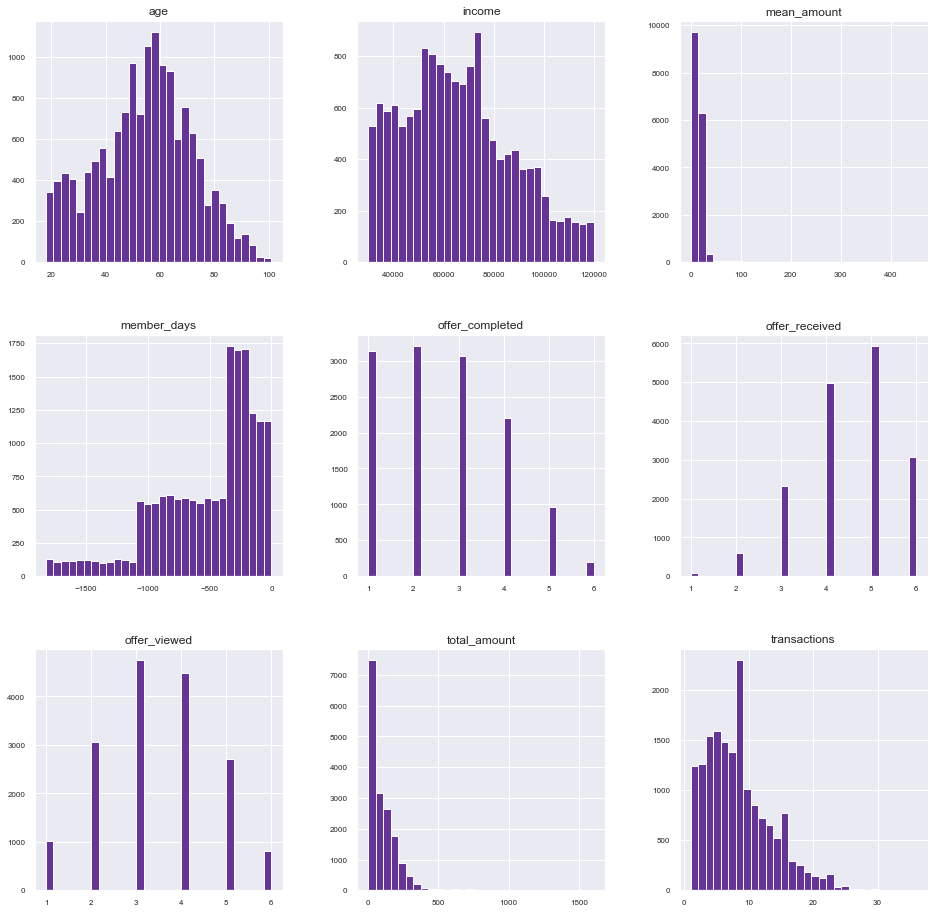

In [9]:
"""plot histograms of numerical data""" # note socio-demographic features missing for 2'175 customers

EDA.plot_num_hist(profile, figsize=(16, 16), bins=30)

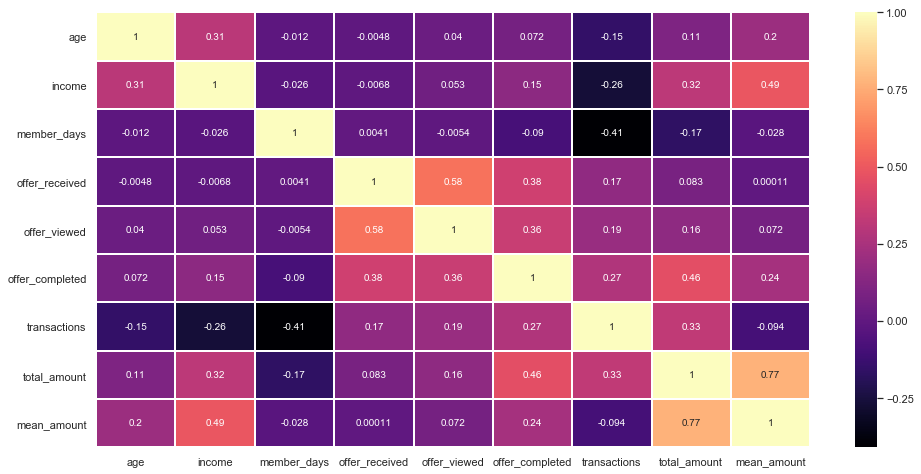

In [10]:
"""show correlation between numerical features"""

EDA.plot_num_corrMap(profile, figsize=(16, 8))

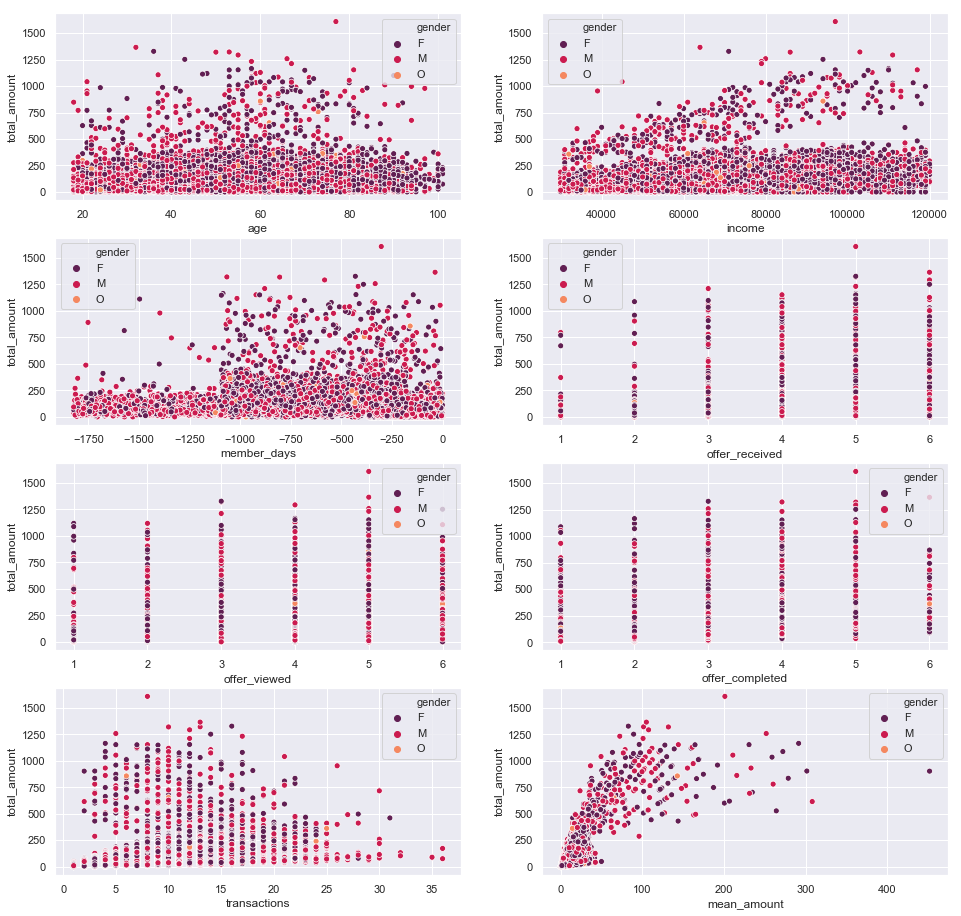

In [18]:
EDA.plot_corr_num_scatter(profile, 'total_amount', hue='gender', figsize=(16, 20))

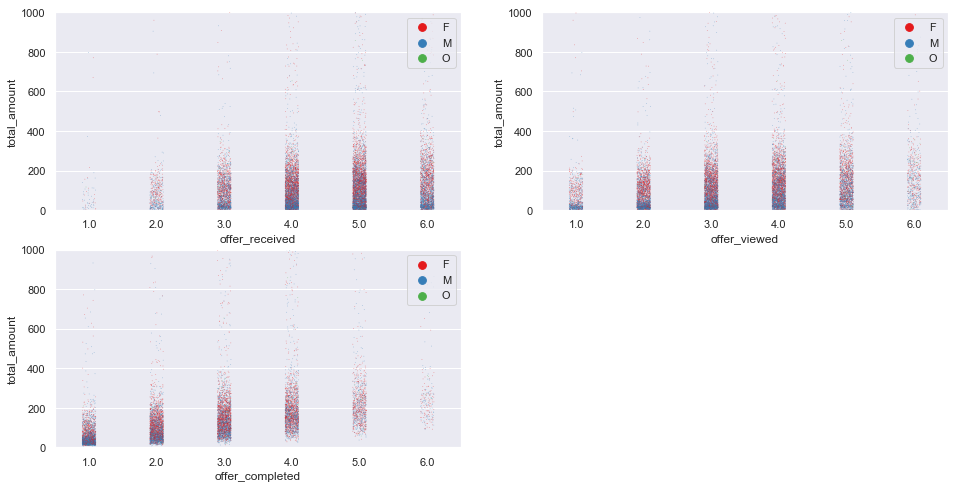

In [12]:
# zoom in on offer data, in relation to total amount

zoom_list = ['offer_received', 'offer_viewed', 'offer_completed']
position = 0
plt.figure(figsize=(16,8))

for pos, col in enumerate(zoom_list):
    position +=1
    plt.subplot((len(zoom_list)/2) + 1, 2 , position)
    sns.stripplot(x=col, y='total_amount', data=profile, palette="Set1", hue='gender', jitter=True, alpha=0.5, size=0.8)
    plt.ylim([0, 1000])  # outliers cut off
    plt.legend(loc='upper right');

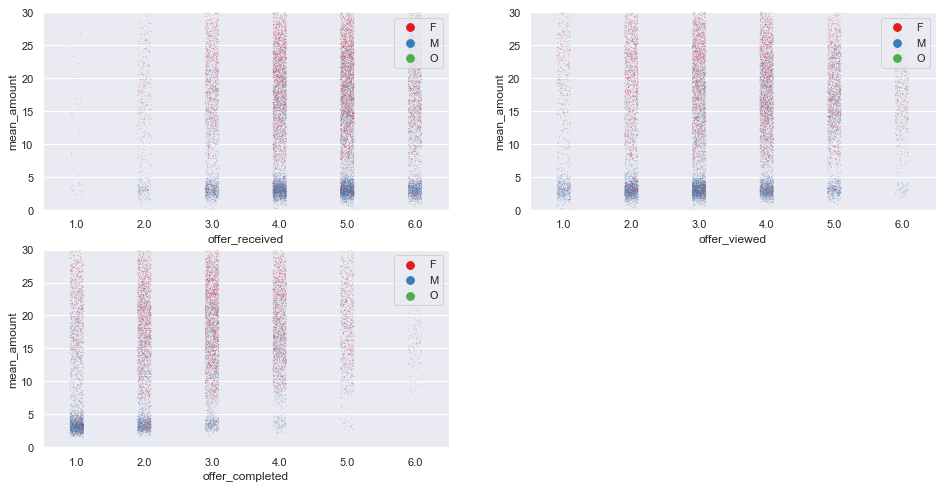

In [20]:
# zoom in on offer data, in relation to mean amount

zoom_list = ['offer_received', 'offer_viewed', 'offer_completed']
position = 0
plt.figure(figsize=(16,8))

for pos, col in enumerate(zoom_list):
    position +=1
    plt.subplot((len(zoom_list)/2) + 1, 2 , position)
    sns.stripplot(x=col, y='mean_amount', data=profile, palette="Set1", hue='gender', jitter=True, alpha=0.5, size=0.8)
    plt.ylim([0, 30])  # outliers cut off
    plt.legend(loc='upper right');

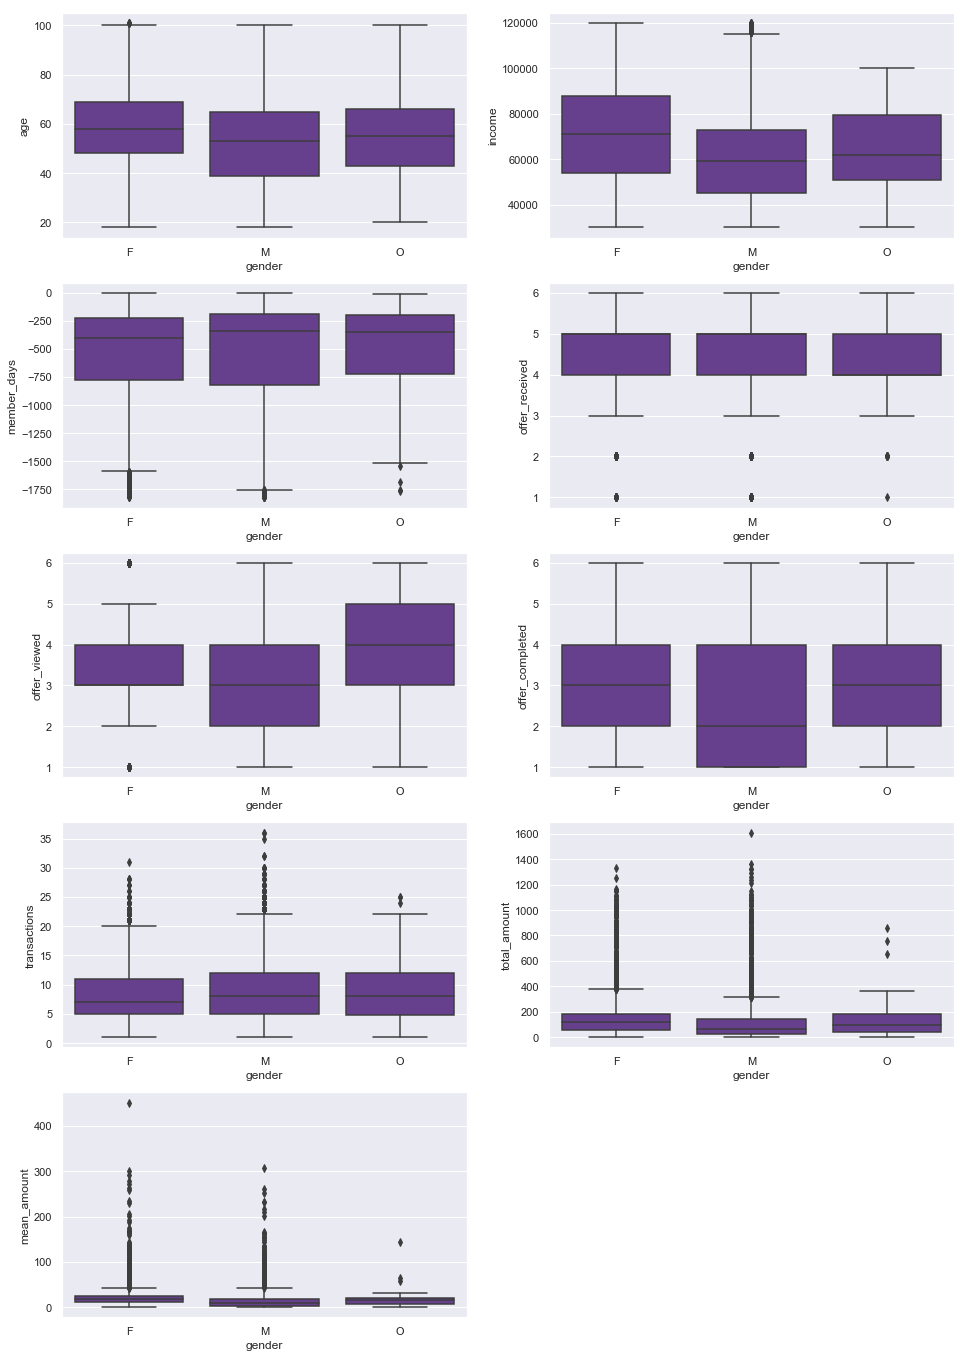

In [13]:
"""show correlation between gender (category) and numerical features""" # note gender is missing for 2'175 customers

EDA.plot_num_corrBox(profile, 'gender', figsize=(16, 24))

## Explore transcript data

Focus on transactions.

In [14]:
display(transcript.head())
display(transcript.info())

,event,person_id,time,amount,offer_id,o_1,o_2,o_3,o_4,o_5,o_6,o_7,o_8,o_9,o_10
0,offer received,p_4,0,NaN,o_3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,offer viewed,p_4,6,NaN,o_3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,transaction,p_4,132,19.89,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer completed,p_4,132,NaN,o_3,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,transaction,p_4,144,17.78,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 15 columns):
event        306534 non-null object
person_id    306534 non-null object
time         306534 non-null int64
amount       138953 non-null float64
offer_id     167581 non-null object
o_1          36790 non-null float64
o_2          32185 non-null float64
o_3          30359 non-null float64
o_4          32714 non-null float64
o_5          31399 non-null float64
o_6          39337 non-null float64
o_7          46677 non-null float64
o_8          29930 non-null float64
o_9          19180 non-null float64
o_10         21410 non-null float64
dtypes: float64(11), int64(1), object(3)
memory usage: 35.1+ MB


None

In [15]:
# count total number of transactions

total_transactions = transcript['event'].value_counts()[0]
print("total number of transactions: ", total_transactions)

total number of transactions:  138953


In [16]:
# check how many transactions are assigned (flagged) to how many promotions each

assert transcript.columns[-10] == 'o_1' # safety-check
transcript['promo_count'] = transcript.iloc[: , -10:].count(axis=1)
transcript.loc[transcript['event'] == 'transaction']['promo_count'].value_counts()

1    87847
2    30719
0    18760
3     1627
Name: promo_count, dtype: int64